In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from ipywidgets import interact, IntSlider

from src.data.dataset import split_dataset, tidy_plays_df
from src.data.data_query import StorageEngine
from src.data.plays_model import game_json_to_plays_list
from src.features.features import basic_features, advanced_features, normalize_plays_coords
#from src.models.xgboost import train_xgb

In [95]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from comet_ml import Experiment


In [120]:
from sklearn import metrics
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import pickle

In [3]:
df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
df, test_df = split_dataset(df)
advanced_df = advanced_features(df)
advanced_df.head()

,seconds_elapsed,period_idx,x_coord,y_coord,x_coord_norm,y_coord_norm,dist_from_net,angle_from_net,Backhand,Deflected,...,SHOT,STOP,TAKEAWAY,previous_x_coord,previous_y_coord,seconds_from_previous,dist_from_previous,rebound,angle_change,speed
5394,51.0,1,-55.0,6.0,55.0,-6.0,34.525353,-10.007980,0,0,...,0,0,0,94.0,-34.0,11.0,154.275727,0,0.000000,14.025066
5395,65.0,1,-79.0,0.0,79.0,-0.0,10.000000,0.000000,0,0,...,0,0,0,-37.0,-28.0,7.0,50.477718,0,0.000000,7.211103
5396,66.0,1,-75.0,-1.0,75.0,1.0,14.035669,4.085617,0,0,...,1,0,0,-79.0,0.0,1.0,4.123106,1,4.085617,4.123106
5397,113.0,1,-55.0,-36.0,55.0,36.0,49.517674,46.636577,0,0,...,0,0,0,-91.0,35.0,18.0,79.605276,0,0.000000,4.422515
5398,157.0,1,-61.0,-1.0,61.0,1.0,28.017851,2.045408,0,0,...,0,0,0,-69.0,-22.0,5.0,22.472205,0,0.000000,4.494441


In [9]:
#df3 = pd.get_dummies(df.shot_type)
df2 = pd.get_dummies(df.period_type)
df['is_goal'] = np.where(df.event_type_id == "GOAL",1,0)
result_df = pd.concat([advanced_df, df2, df[['is_goal']]], axis=1).round(2).fillna(0)
dff = result_df.replace({np.nan: 0, np.inf:0, -np.inf:0})

#### Create train and validation set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['is_goal','empty_net'],axis=1).fillna(0), dff['is_goal'], test_size=0.30, random_state=42)


### feature selection

In [11]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True False False False  True
  True  True  True False  True  True  True  True  True  True False  True
  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 7 1 1 1 1 5 8 2 1 1 1 1 6 1 1 1 1 1 1 3 1 1]


/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
feature_select = pd.DataFrame()
feature_select['features'] = X_train.columns
feature_select['RFE_select'] = fit.support_

In [13]:
model = RandomForestClassifier(random_state = 42)
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False False False
  True False  True  True  True  True  True  True  True  True False  True
 False]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 7 5 8 1 4 1 1 1 1 1 1 1 1 2 1 3]


In [24]:
feature_select['RFE_random_forest'] = fit.support_
feature_select['select'] = np.where((feature_select['RFE_select']==True)&(feature_select['RFE_select']==True),1,0)
features = feature_select[feature_select['select']==1]['features'].tolist()

In [16]:
from xverse.transformer import WOE
clf = WOE()
clf.fit(X_train, y_train)

WOE(mono_custom_binning={'BLOCKED_SHOT': array([0., 1.]),
                         'Backhand': array([0., 1.]),
                         'Deflected': array([0., 1.]),
                         'FACEOFF': array([0., 1.]),
                         'GIVEAWAY': array([0., 1.]), 'GOAL': array([0., 1.]),
                         'HIT': array([0., 1.]), 'MISSED_SHOT': array([0., 1.]),
                         'OTHER': array([0., 1.]), 'OVERTIME': array([0., 1.]),
                         'PENALTY': array([0., 1.]),
                         'PERIOD_START': array([0., 1.]),
                         'REGULAR': array...
                                   Interval(-54.0, 54.0, closed='right'): -0.05189122790246956,
                                   Interval(54.0, 99.0, closed='right'): 0.02154891839684451},
              'previous_y_coord': {Interval(-42.001, -13.0, closed='right'): -0.12960622948947284,
                                   Interval(-13.0, 13.0, closed='right'): 0.21013923124825637,

In [20]:
temp = pd.DataFrame(clf.iv_df)
temp[temp['Information_Value']>0.3]

,Variable_Name,Information_Value
24,dist_from_net,0.447066
34,x_coord_norm,0.303175


### Model building

#### MLP classifier

In [78]:
## Hyperparameter tuning
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    
}
clf = RandomizedSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train[features], y_train)
# Best parameter set
print('Best parameters found:\n', clf.best_params_)


Best parameters found:
 {'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.05, 'activation': 'tanh'}


/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/ana

In [82]:
## MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train[features], y_train)


In [83]:
print(classification_report(y_test, clf.predict(X_test[features])))
print(classification_report(y_train, clf.predict(X_train[features])))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     84601
           1       0.42      0.03      0.06      8731

    accuracy                           0.91     93332
   macro avg       0.67      0.51      0.50     93332
weighted avg       0.86      0.91      0.87     93332

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    197318
           1       0.47      0.03      0.06     20456

    accuracy                           0.91    217774
   macro avg       0.69      0.51      0.51    217774
weighted avg       0.87      0.91      0.87    217774



In [123]:
experiment.log_confusion_matrix(
   np.array(y_test),
    clf.predict(X_test[features]),
    step=0,
    title="Confusion Matrix-MLP, ",
    file_name="confusion-matrix-MLP-%03d.json" % 0,

)

{'web': 'https://www.comet.ml/api/asset/download?assetId=ee59e14228d74947a2858fad4cfadd83&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=ee59e14228d74947a2858fad4cfadd83&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'assetId': 'ee59e14228d74947a2858fad4cfadd83'}

### Random forest

In [74]:
rnd_mdl = RandomForestClassifier(random_state = 42, class_weight = {0: 0.2, 1: 0.8}
                      )
param1 = {'max_depth':[5,6,10], 'n_estimators':[100, 300, 500]}
random_clf = RandomizedSearchCV(rnd_mdl, param1, random_state=42, cv=5, n_jobs=-1)

random_clf.fit(X_train[features], y_train)

The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.2,
                                                                  1: 0.8},
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42)

In [76]:
random_clf.best_estimator_

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=5,
                       n_estimators=500, random_state=42)

In [77]:

randomForest = RandomForestClassifier(random_state = 42, max_depth=5, class_weight = {0: 0.2, 1: 0.8}, n_estimators=500).fit(X_train[features], y_train)
print(classification_report(y_test, randomForest.predict(X_test[features])))
print(classification_report(y_train, randomForest.predict(X_train[features])))


              precision    recall  f1-score   support

           0       0.92      0.97      0.94     84601
           1       0.32      0.14      0.20      8731

    accuracy                           0.89     93332
   macro avg       0.62      0.55      0.57     93332
weighted avg       0.86      0.89      0.87     93332

              precision    recall  f1-score   support

           0       0.92      0.97      0.94    197318
           1       0.31      0.13      0.19     20456

    accuracy                           0.89    217774
   macro avg       0.61      0.55      0.56    217774
weighted avg       0.86      0.89      0.87    217774



In [124]:
experiment.log_confusion_matrix(
   np.array(y_test),
    randomForest.predict(X_test[features]),
    step=0,
    title="Confusion Matrix-Random-forest, ",
    file_name="confusion-matrix-Random-forest-%03d.json" % 0,

)

{'web': 'https://www.comet.ml/api/asset/download?assetId=c8f85a8753674150a8751c5259ba78f5&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=c8f85a8753674150a8751c5259ba78f5&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'assetId': 'c8f85a8753674150a8751c5259ba78f5'}

In [121]:
acc= accuracy_score(clf.predict(X_test[features]), y_test)
experiment.log_metric("accuracy-MLP", acc)
acc1 = accuracy_score(randomForest.predict(X_test[features]), y_test)
experiment.log_metric("accuracy-Random-forest", acc1)
acc2 = accuracy_score(model.predict(X_test[features]), y_test)
experiment.log_metric("accuracy-Lightgbm", acc2)

### Light gbm hyperparameter tuning

In [30]:
##Lightgbm
mdl = LGBMClassifier(objective="binary" ,class_weight={0:0.2,1:0.8,},
                       metric="auc", random_state=42,
                     #n_estimators=500  
                       #min_split_gain = 23
                      )
param1 = {'min_gain_to_split':[0.1, 0.3, 0.5, 0.6],"reg_alpha" :[0.4, 1],
"reg_lambda" : [0.7, 1],}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train[features], y_train)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.2, 1: 0.8},
                                            metric='auc', objective='binary',
                                            random_state=42),
                   param_distributions={'min_gain_to_split': [0.1, 0.3, 0.5,
                                                              0.6],
                                        'reg_alpha': [0.4, 1],
                                        'reg_lambda': [0.7, 1]},
                   random_state=42)

In [31]:
clf.best_estimator_

LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.1, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.7)

In [32]:

model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.1, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.7)
model.fit(X_train[features], y_train)
ypred = model.predict(X_test[features])
y_tr_pred = model.predict(X_train[features])



In [125]:
experiment.log_confusion_matrix(
   np.array(y_test),
    model.predict(X_test[features]),
    step=0,
    title="Confusion Matrix-LGBM, ",
    file_name="confusion-matrix-LGBM-%03d.json" % 0,

)

{'web': 'https://www.comet.ml/api/asset/download?assetId=3bb7d05bb6b04dc3bb960819e1f2430f&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=3bb7d05bb6b04dc3bb960819e1f2430f&experimentKey=39759444e7444d1ba87933c4e1a99094',
 'assetId': '3bb7d05bb6b04dc3bb960819e1f2430f'}

In [38]:
print('test')
print(classification_report(y_test, model.predict(X_test[features])))
print('train')
print(classification_report(y_train, model.predict(X_train[features])))

test
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     84601
           1       0.30      0.33      0.32      8731

    accuracy                           0.87     93332
   macro avg       0.62      0.63      0.62     93332
weighted avg       0.87      0.87      0.87     93332

train
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    197318
           1       0.32      0.35      0.34     20456

    accuracy                           0.87    217774
   macro avg       0.63      0.64      0.63    217774
weighted avg       0.87      0.87      0.87    217774



/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


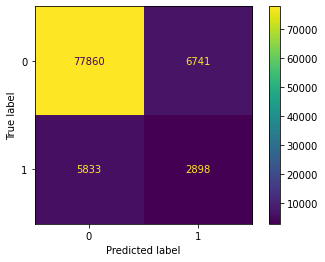

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test[features], y_test)

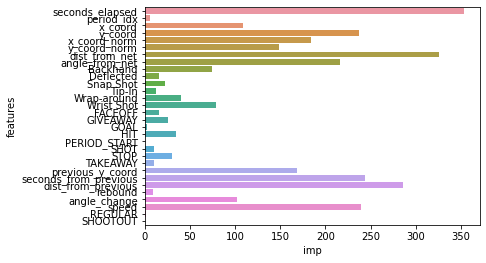

In [40]:
feature_imp = pd.DataFrame()
feature_imp['features'] = features
feature_imp['imp'] = model.feature_importances_

ax = sns.barplot(x="imp", y="features", data=feature_imp)

In [49]:
path = '/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/'
filename = path+'lgbm.sav'
pickle.dump(model, open(filename, 'wb'))
filename = path+'randomForest.sav'
pickle.dump(randomForest, open(filename, 'wb'))
filename = path+'MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

In [50]:
%%writefile src/models/best_model.py
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)
path = "/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/"

experiment.log_model("Best model-LightGBM", path+"lgbm.sav")
experiment.log_model("MLP", path+"MLP.sav")
experiment.log_model("Random forest", path+"randomForest.sav")
experiment.end()

Overwriting src/models/best_model.py


In [70]:
print("features used", features)

features used ['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm', 'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand', 'Deflected', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot', 'FACEOFF', 'GIVEAWAY', 'GOAL', 'HIT', 'PERIOD_START', 'SHOT', 'STOP', 'TAKEAWAY', 'previous_y_coord', 'seconds_from_previous', 'dist_from_previous', 'rebound', 'angle_change', 'speed', 'REGULAR', 'SHOOTOUT']


In [127]:
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/zilto/hockey-all-star-analytics/e1befcdc7ea2498e83f7fa40c58b2512



In [86]:

def goal_Rate(pred, y_test): 
    valid = pd.DataFrame()
    valid['pred_prob'] = pred#clf.predict_proba(X_test)[::,1]
    valid['true_labels'] = np.array(y_test)
    percentile = [[np.percentile(valid['pred_prob'], i), np.percentile(valid['pred_prob'], i+5)] for i in range(0,100,5)]

    goal_rate = []
    cum=0
    for i in range(0, len(percentile)):
        goals = valid[ (valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==1)].shape[0]

        no_goals = valid[(valid['pred_prob']<=percentile[i][1])&(valid['pred_prob']>percentile[i][0]) & (valid['true_labels']==0)].shape[0]

        if goals==0:
            goal_rate.append(0)
        else:
            goal_rate.append((goals*100)/(goals+no_goals))
    total_goal = valid[valid['true_labels']==1].shape[0]
    cumulative = []
    for i in range(0, len(percentile)-1):
        goals = valid[(valid['pred_prob']>=percentile[i][0]) & (valid['true_labels']==1)].shape[0]
        cumulative.append(goals*100/total_goal)
    cumulative.append(0)
        
    Shot_prob_percentile = [i for i in range(0,100, 5)]
    return goal_rate, cumulative, Shot_prob_percentile 

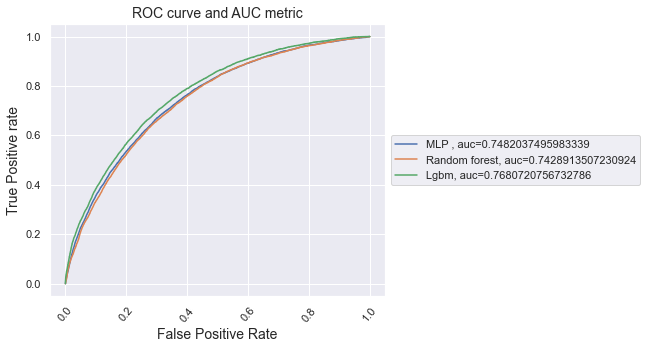

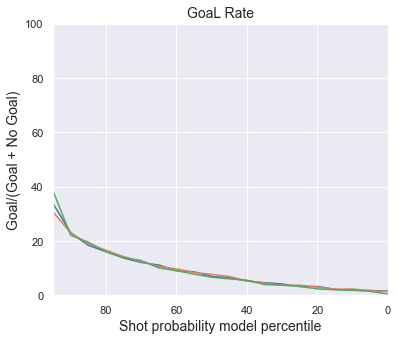

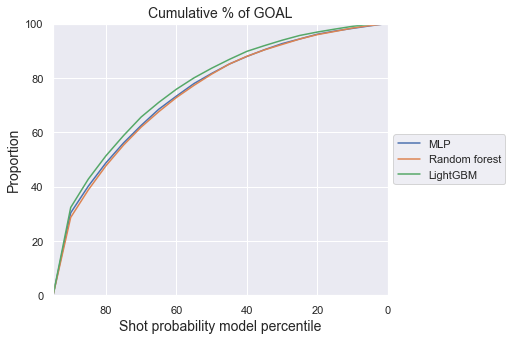

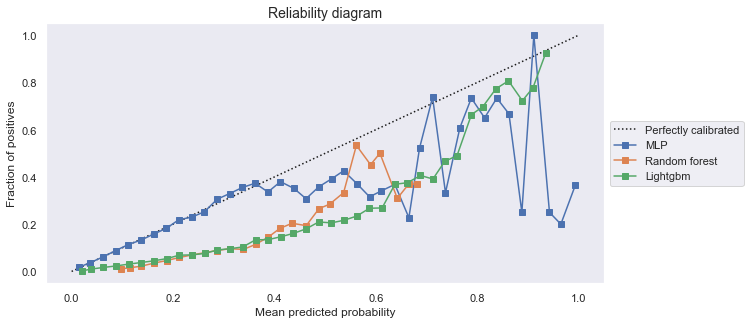

In [133]:
def plots_evaluation(MLP_rate, MLP_cum, Random_forest_rate, Random_forest_cum, Lgbm_rate, lgbm_cum, y_test,y_pred_mlp, y_pred_random_forest, y_pred_lgbm, Shot_percentile):
    sns.set(rc={'figure.figsize':(6,5)})
    path = "/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/"
    fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test, y_pred_mlp)
    auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp)
    plt.plot(fpr_mlp, tpr_mlp,label="MLP , auc="+str(auc_mlp))
    experiment.log_metric("MLP auc: ", auc_mlp)
    
    fpr_random_forest, tpr_random_forest, _ = metrics.roc_curve(y_test, y_pred_random_forest)
    auc_random_forest = metrics.roc_auc_score(y_test, y_pred_random_forest)
    plt.plot(fpr_random_forest,tpr_random_forest,label="Random forest, auc="+str(auc_random_forest))
    experiment.log_metric("Random forest auc: ", auc_random_forest)
    
    fpr_lgbm, tpr_lgbm, _ = metrics.roc_curve(y_test, y_pred_lgbm)
    auc_lgbm = metrics.roc_auc_score(y_test, y_pred_lgbm)
    plt.plot(fpr_lgbm,tpr_lgbm,label="Lgbm, auc="+str(auc_lgbm))
    experiment.log_metric("Light gbm auc: ", auc_lgbm)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=50)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive rate', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("ROC curve and AUC metric",fontsize=14)
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/ROC_AUC_Q6.png",bbox_inches="tight")
    experiment.log_figure(figure_name="AUC_ROC ", overwrite=False, step=None)
    plt.show()
    
    plt.plot(Shot_percentile, MLP_rate, label="MLP")
    plt.plot(Shot_percentile, Random_forest_rate, label="Random forest")
    plt.plot(Shot_percentile, Lgbm_rate, label="Lgbm")
    plt.xlim(max(Shot_percentile), min(Shot_percentile))
    plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Goal/(Goal + No Goal)', fontsize=14)
    plt.title("GoaL Rate",fontsize=14)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Goal_rate_Q6.png",bbox_inches="tight")
    
    experiment.log_figure(figure_name = "Goal rate vs Shot probability model percentile", overwrite=False, step=None) 
    plt.show()
    
    plt.plot(Shot_percentile, MLP_cum, label="MLP")
    plt.plot(Shot_percentile, Random_forest_cum, label="Random forest")
    plt.plot(Shot_percentile, lgbm_cum, label="LightGBM")
    plt.xlim(max(Shot_percentile), min(Shot_percentile))
    plt.ylim(0, 100)
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Cumulative % of GOAL",fontsize=14)
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/cum_Shot_prob_Q6.png",bbox_inches="tight")
    experiment.log_figure(figure_name = "Proportion vs Shot probability model percentile", overwrite=False, step=None) 
    plt.show()

    
    clf_list = [(y_pred_mlp,'MLP'),(y_pred_random_forest,'Random forest'),(y_pred_lgbm,'Lightgbm')]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_predictions(
            
            y_test,
            clf,
            name=name,
            n_bins=40,
            ax=ax_calibration_curve,
            
        )
        calibration_displays[name] = display

    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Reliability diagram",fontsize=14)
    plt.savefig("/Users/henaghonia/Desktop/udem/Sem-1/Data-science/ift6758-Milestone2_blog/ift6758-Milestone2_blog/images/Calibration_Q6.png",bbox_inches="tight")
    experiment.log_figure(figure_name = "Calibration plot", overwrite=False, step=None) 


    
y_pred_mlp = clf.predict_proba(X_test[features])[::,1]    
MLP_rate, MLP_cum, Shot_percentile =  goal_Rate(y_pred_mlp, y_test)

y_pred_random_forest = random_clf.predict_proba(X_test[features])[::,1]    
Random_forest_rate, Random_forest_cum, Shot_percentile =  goal_Rate(y_pred_random_forest, y_test)

y_pred_lgbm = model.predict_proba(X_test[features])[::,1]    
Lgbm_rate, lgbm_cum, Shot_percentile =  goal_Rate(y_pred_lgbm, y_test)
    
plots_evaluation(MLP_rate, MLP_cum, Random_forest_rate, Random_forest_cum, Lgbm_rate, lgbm_cum, y_test,y_pred_mlp, y_pred_random_forest, y_pred_lgbm, Shot_percentile)



In [129]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zilto/hockey-all-star-analytics/e1befcdc7ea2498e83f7fa40c58b2512
COMET INFO:   Metrics:
COMET INFO:     Light gbm auc:      : 0.7680720756732786
COMET INFO:     MLP auc:            : 0.7482037495983339
COMET INFO:     Random forest auc:  : 0.7428913507230924
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (548.74 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading 1 metrics, params and output messages


### For test data

In [59]:
def feature_data(test_df):
    test_advanced_df = advanced_features(test_df)
    test_df2 = pd.get_dummies(test_df.period_type)
    test_df['is_goal'] = np.where(test_df.event_type_id == "GOAL",1,0)
    result_df = pd.concat([test_advanced_df, test_df2, test_df[['is_goal','game_type']]], axis=1).round(2).fillna(0)
    test_data = result_df.replace({np.nan: 0, np.inf:0, -np.inf:0})
    
    return test_data[(test_data['game_type']=="R")], test_data[(test_data['game_type']=="P")]
Regular_test, play_off_test = feature_data(test_df)

In [63]:
Regualar_pred = pd.DataFrame()
Regualar_pred['pred_proba'] = model.predict_proba(Regular_test[features])[::,1]
Regualar_pred['Prediction'] = model.predict(Regular_test[features])
Regualar_pred['actual'] = np.array(Regular_test['is_goal'])

In [64]:
playoff_pred = pd.DataFrame()
playoff_pred['pred_proba'] = model.predict_proba(play_off_test[features])[::,1]
playoff_pred['Prediction'] = model.predict(play_off_test[features])
playoff_pred['actual'] = np.array(play_off_test['is_goal'])

In [68]:
playoff_pred.to_csv('data/processed/play_off_prediction.csv', index=False)
Regualar_pred.to_csv('data/processed/Regualar_prediction.csv', index=False)

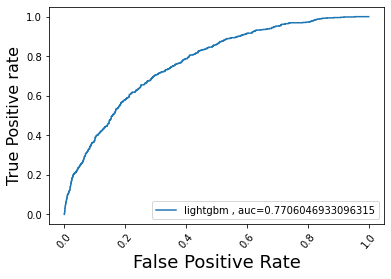

In [66]:
y_pred_proba = playoff_pred['pred_proba']
fpr, tpr, _ = metrics.roc_curve(playoff_pred['actual'],  y_pred_proba)
auc = metrics.roc_auc_score(playoff_pred['actual'], y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

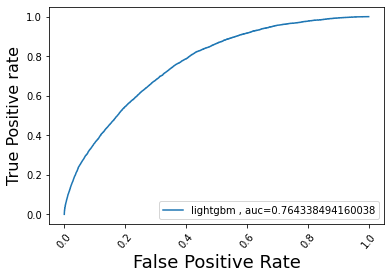

In [67]:
y_pred_proba = Regualar_pred['pred_proba']
fpr, tpr, _ = metrics.roc_curve(Regualar_pred['actual'],  y_pred_proba)
auc = metrics.roc_auc_score(Regualar_pred['actual'], y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()